In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats
import geopandas as gpd
%matplotlib inline
from IPython.display import Markdown
from functools import reduce
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [3]:
dataframe = pd.read_csv("data/RV_O_010_L_OK_SK.CSV", sep=';')
dataframe.head()

,Kód okresu,Názov okresu,Pohlavie,Ekonomické vekové skupiny,Vzdelanie,abs.
0,SK0101,Okres Bratislava I,muž,predproduktívny vek (0-14 rokov),dôverné,1
1,SK0101,Okres Bratislava I,muž,predproduktívny vek (0-14 rokov),nezistené,56
2,SK0101,Okres Bratislava I,muž,predproduktívny vek (0-14 rokov),základné vzdelanie - 1. stupeň základnej školy,835
3,SK0101,Okres Bratislava I,muž,predproduktívny vek (0-14 rokov),základné vzdelanie - 2. stupeň základnej školy,2
4,SK0101,Okres Bratislava I,muž,predproduktívny vek (0-14 rokov),bez ukončeného vzdelania – osoby vo veku 0-14 ...,2671


In [4]:
url = "https://bbrejova.github.io/viz/data/districts.json"
districts = gpd.read_file(url)
districts.head()

,LAU1,DOW,IDN3,NM3,IDN2,NM2,NUTS2,NUTS2_CODE,NUTS3,NUTS3_CODE,LAU1_CODE,LAU2,LAU2_CODE,geometry
0,Banská Bystrica,2021-02-26 00:00:00+00:00,601,Banská Bystrica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,SK0321,Badín,SK0321508454,"POLYGON ((-408449.300 -1239367.000, -408777.00..."
1,Banská Štiavnica,2021-02-26 00:00:00+00:00,602,Banská Štiavnica,6,Banskobystrický,Stredné Slovensko,SK03,Banskobystrický kraj,SK032,SK0322,Svätý Anton,SK0322516597,"POLYGON ((-440822.840 -1272799.420, -440809.15..."
2,Bardejov,2021-02-26 00:00:00+00:00,701,Bardejov,7,Prešovský,Východné Slovensko,SK04,Prešovský kraj,SK041,SK0411,Abrahámovce,SK0411519014,"POLYGON ((-251311.230 -1194615.930, -251463.13..."
3,Bratislava I,2021-02-26 00:00:00+00:00,101,Bratislava I,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,SK0101,Bratislava-Staré Mesto,SK0101528595,"POLYGON ((-575659.050 -1277509.490, -575929.03..."
4,Bratislava II,2021-02-26 00:00:00+00:00,102,Bratislava II,1,Bratislavský,Bratislavský kraj,SK01,Bratislavský kraj,SK010,SK0102,Bratislava-Ružinov,SK0102529320,"POLYGON ((-564128.190 -1281777.370, -563932.30..."


In [5]:
merged = districts.merge(dataframe, right_on='Kód okresu', left_on='LAU1_CODE')
merged.info()
merged['abs.'].sum()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   LAU1                       7017 non-null   object             
 1   DOW                        7017 non-null   datetime64[ns, UTC]
 2   IDN3                       7017 non-null   int64              
 3   NM3                        7017 non-null   object             
 4   IDN2                       7017 non-null   int64              
 5   NM2                        7017 non-null   object             
 6   NUTS2                      7017 non-null   object             
 7   NUTS2_CODE                 7017 non-null   object             
 8   NUTS3                      7017 non-null   object             
 9   NUTS3_CODE                 7017 non-null   object             
 10  LAU1_CODE                  7017 non-null   object             
 

5449270

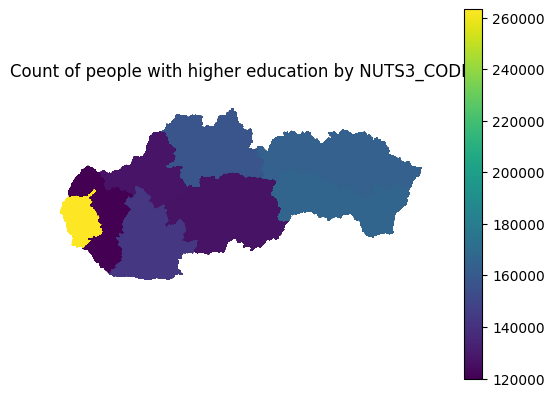

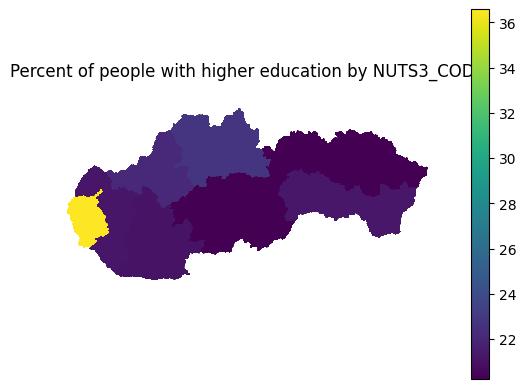

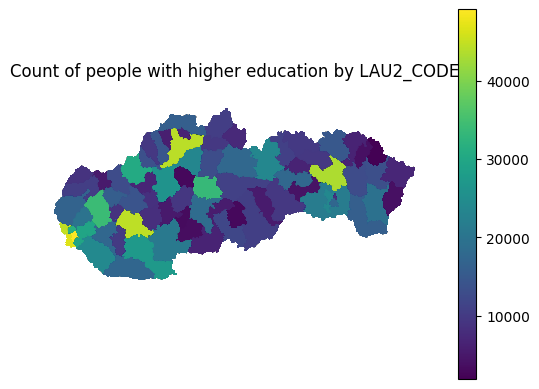

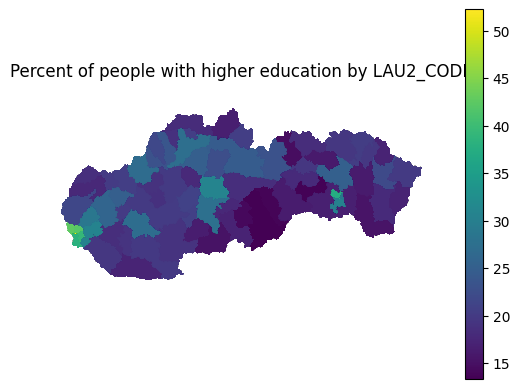

In [18]:
def with_selected_edu(dataframe: pd.DataFrame, geo_unit: str, selected_edu: list[str], kind: ('count', 'percent')='percent'):
    series_list = [dataframe['Vzdelanie'] == edu for edu in selected_edu]
    selected_edu = reduce(lambda x, y: x | y, series_list, pd.Series(False, index=dataframe['Vzdelanie'].index))
    selected = dataframe[selected_edu]
    edu_count = selected.groupby(geo_unit)['abs.'].sum().rename('count')
    edu_unit = edu_count.reset_index()
    if kind == 'count':
        to_merge = edu_unit
    elif kind == 'percent':
        population_count = dataframe.groupby(geo_unit)['abs.'].sum().rename('population')
        population_unit = population_count.reset_index()
        to_merge = pd.merge(population_unit, edu_unit, on=geo_unit)
        to_merge['percent'] = 100 * to_merge['count'] / to_merge['population']
    else:
        raise "Given kind is not supported"
    merged = dataframe.merge(to_merge, on=geo_unit)
    merged.plot(column=kind, legend=True)
    plt.title(f'{kind.capitalize()} of people with higher education by {geo_unit}')
    plt.axis('off')
    plt.show()

edu_types = merged['Vzdelanie'].unique()
high_edu = edu_types[14:22]
with_selected_edu(merged, 'NUTS3_CODE', high_edu, kind='count')
with_selected_edu(merged, 'NUTS3_CODE', high_edu, kind='percent')
with_selected_edu(merged, 'LAU2_CODE', high_edu, kind='count')
with_selected_edu(merged, 'LAU2_CODE', high_edu, kind='percent')

In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4("Select style for the plot: "),
    dcc.Checklist(
        id='selected_edu',
        options=[{'label': v, 'value': i} for i, v in enumerate(edu_types)],
        value=[0]
    ),
    dcc.Graph(id='geo-map'),
])

@app.callback(
    Output('geo-map', 'figure'),
    [Input('selected_edu', 'value')]
)
def update_figure(selected_edu):
    figure = with_selected_edu(merged, 'NUTS3_CODE', selected_edu)

    return figure

app.run_server(mode='inline', port=8051)